In [155]:
import torch
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [170]:
class EEGNET(nn.Module):
    def __init__(self,act=nn.ELU(alpha=1.)):
        super(EEGNET,self).__init__()
        self.firstconv=nn.Sequential(
            nn.Conv2d(1,16,(1,51),(1,1),padding=(0,25),bias=False),
            nn.BatchNorm2d(16,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True)
        )
        self.depthwiseConv=nn.Sequential(
            nn.Conv2d(16,32,(2,1),(1,1),groups=16,bias=False),
            nn.BatchNorm2d(32,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True),
            act,
            nn.AvgPool2d((1,4),stride=(1,4),padding=0),
            nn.Dropout(p=0.25)
        )
        self.separableConv=nn.Sequential(
            nn.Conv2d(32,32,(1,15),(1,1),padding=(0,7),bias=False),
            nn.BatchNorm2d(32,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True),
            act,
            nn.AvgPool2d((1,8),stride=(1,8),padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify=nn.Sequential(
            nn.Linear(in_features=736,out_features=2,bias=True)
        )
    def forward(self,x):
        x=self.firstconv(x)
        x=self.depthwiseConv(x)
        x=self.separableConv(x)
        x=x.view(-1,736)
        x=self.classify(x)
        return x

In [157]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class DeepConvNet(nn.Module):
    def __init__(self,act=nn.ELU(alpha=1.),C=2,T=750,N=2):
        super(DeepConvNet,self).__init__()
        self.net=nn.Sequential(
            nn.Conv2d(1,25,(1,5)),
            nn.Conv2d(25,25,(C,1)),
            nn.BatchNorm2d(25,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True),
            act,
            nn.MaxPool2d((1,2),stride=(1,2),padding=0),
            nn.Dropout(p=0.5),
            nn.Conv2d(25,50,(1,5)),
            nn.BatchNorm2d(50,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True),
            act,
            nn.MaxPool2d((1,2),stride=(1,2),padding=0),
            nn.Dropout(p=0.5),
            nn.Conv2d(50,100,(1,5)),
            nn.BatchNorm2d(100,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True),
            act,
            nn.MaxPool2d((1,2),stride=(1,2),padding=0),
            nn.Dropout(p=0.5),
            nn.Conv2d(100,200,(1,5)),
            nn.BatchNorm2d(200,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True),
            act,
            nn.MaxPool2d((1,2),stride=(1,2),padding=0),
            nn.Dropout(p=0.5),
            Flatten(),
            nn.Linear(8600,2)
        )
    def forward(self,x):
        x=self.net(x)
        return x

In [158]:
def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

    print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

    return train_data, train_label, test_data, test_label

In [159]:
train_data, train_label, test_data, test_label=read_bci_data()
train_data, train_label, test_data, test_label=read_bci_data()


train_data=torch.Tensor(train_data).cuda()
train_label=torch.Tensor(train_label).cuda()
test_data=torch.Tensor(test_data).cuda()
test_label=torch.Tensor(test_label).cuda()

train_dataset=Data.TensorDataset(train_data,train_label)
test_dataset=Data.TensorDataset(test_data,test_label)



(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)
(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


In [245]:
model=EEGNET()
print(model)

model=DeepConvNet()
print(model)

EEGNET(
  (firstconv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwiseConv): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25)
  )
  (separableConv): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.25)
  )
  (classify): Sequential(
    (0): Linear(in_features=736, out_features=2, bias=True)
  )
)
DeepConvNet(
  (net): Sequential(
    (0): Con

### EEG

In [246]:
BATCH_SIZE=32
LR=1e-3
EPOCHS=300
loss_func=nn.CrossEntropyLoss()

train_loader=Data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader=Data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [247]:
actList=[nn.LeakyReLU(),nn.ReLU(),nn.ELU(alpha=1.)]
actStr=['LeakyReLU','ReLU','ELU']

trainAcc=[]
testAcc=[]
Loss=[]
count=0



for a in actList:
    model=EEGNET(a)
    model.cuda()
    optimizer=optim.Adam(model.parameters(),lr=LR)

    lossValues=[]
    trainAccValues=[]
    testAccValues=[]
    MaxAcc=0
    for epoch in range(EPOCHS):
        model.train()
        predicted=[]
        acc=0
        for index,(x,y) in enumerate(train_loader):
            x=Variable(x)
            y=y.view(-1).long()
            _y=model(x)
            loss=loss_func(_y,y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            y=y.cpu().numpy()
            _y=_y.cpu().detach().numpy()
            predicts=(np.argmax(_y,axis=1)==y)
            acc+=np.count_nonzero(predicts)
        
        print(a,"Epoch: [%3d], Loss: %.5f" %(epoch + 1, loss.data))
        lossValues.append(loss.data)
        trainAccValues.append(acc/train_data.shape[0])
        
        model.eval()
        predicted=[]
        acc=0
        for index,(x,y) in enumerate(test_loader):
            _y=model(x)
            y=y.cpu().numpy()
            _y=_y.cpu().detach().numpy()
            predicts=(np.argmax(_y,axis=1)==y)
            acc+=np.count_nonzero(predicts)
        if (acc/test_data.shape[0])>MaxAcc:
            MaxAcc=acc/test_data.shape[0]
            torch.save(model, actStr[count]+'_EEGNet.pkl') 
        testAccValues.append(acc/test_data.shape[0])
    testAcc.append(testAccValues)
    trainAcc.append(trainAccValues)
    Loss.append(lossValues)
    print(a," Acc: "+str(MaxAcc))
    count+=1

LeakyReLU(negative_slope=0.01) Epoch: [  1], Loss: 0.45373


C:\Users\ec131b\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type EEGNET. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


LeakyReLU(negative_slope=0.01) Epoch: [  2], Loss: 0.37225
LeakyReLU(negative_slope=0.01) Epoch: [  3], Loss: 0.46090
LeakyReLU(negative_slope=0.01) Epoch: [  4], Loss: 0.39279
LeakyReLU(negative_slope=0.01) Epoch: [  5], Loss: 0.51969
LeakyReLU(negative_slope=0.01) Epoch: [  6], Loss: 0.45650
LeakyReLU(negative_slope=0.01) Epoch: [  7], Loss: 0.32302
LeakyReLU(negative_slope=0.01) Epoch: [  8], Loss: 0.44605
LeakyReLU(negative_slope=0.01) Epoch: [  9], Loss: 0.47749
LeakyReLU(negative_slope=0.01) Epoch: [ 10], Loss: 0.49844
LeakyReLU(negative_slope=0.01) Epoch: [ 11], Loss: 0.28159
LeakyReLU(negative_slope=0.01) Epoch: [ 12], Loss: 0.31343
LeakyReLU(negative_slope=0.01) Epoch: [ 13], Loss: 0.32844
LeakyReLU(negative_slope=0.01) Epoch: [ 14], Loss: 0.31818
LeakyReLU(negative_slope=0.01) Epoch: [ 15], Loss: 0.28075
LeakyReLU(negative_slope=0.01) Epoch: [ 16], Loss: 0.40286
LeakyReLU(negative_slope=0.01) Epoch: [ 17], Loss: 0.54800
LeakyReLU(negative_slope=0.01) Epoch: [ 18], Loss: 0.264

LeakyReLU(negative_slope=0.01) Epoch: [140], Loss: 0.01976
LeakyReLU(negative_slope=0.01) Epoch: [141], Loss: 0.02016
LeakyReLU(negative_slope=0.01) Epoch: [142], Loss: 0.04324
LeakyReLU(negative_slope=0.01) Epoch: [143], Loss: 0.03564
LeakyReLU(negative_slope=0.01) Epoch: [144], Loss: 0.03667
LeakyReLU(negative_slope=0.01) Epoch: [145], Loss: 0.04268
LeakyReLU(negative_slope=0.01) Epoch: [146], Loss: 0.01598
LeakyReLU(negative_slope=0.01) Epoch: [147], Loss: 0.07672
LeakyReLU(negative_slope=0.01) Epoch: [148], Loss: 0.02435
LeakyReLU(negative_slope=0.01) Epoch: [149], Loss: 0.01534
LeakyReLU(negative_slope=0.01) Epoch: [150], Loss: 0.01876
LeakyReLU(negative_slope=0.01) Epoch: [151], Loss: 0.03869
LeakyReLU(negative_slope=0.01) Epoch: [152], Loss: 0.02013
LeakyReLU(negative_slope=0.01) Epoch: [153], Loss: 0.02468
LeakyReLU(negative_slope=0.01) Epoch: [154], Loss: 0.05613
LeakyReLU(negative_slope=0.01) Epoch: [155], Loss: 0.00774
LeakyReLU(negative_slope=0.01) Epoch: [156], Loss: 0.008

LeakyReLU(negative_slope=0.01) Epoch: [278], Loss: 0.02051
LeakyReLU(negative_slope=0.01) Epoch: [279], Loss: 0.02006
LeakyReLU(negative_slope=0.01) Epoch: [280], Loss: 0.00549
LeakyReLU(negative_slope=0.01) Epoch: [281], Loss: 0.01057
LeakyReLU(negative_slope=0.01) Epoch: [282], Loss: 0.02660
LeakyReLU(negative_slope=0.01) Epoch: [283], Loss: 0.00612
LeakyReLU(negative_slope=0.01) Epoch: [284], Loss: 0.00279
LeakyReLU(negative_slope=0.01) Epoch: [285], Loss: 0.01615
LeakyReLU(negative_slope=0.01) Epoch: [286], Loss: 0.01137
LeakyReLU(negative_slope=0.01) Epoch: [287], Loss: 0.01589
LeakyReLU(negative_slope=0.01) Epoch: [288], Loss: 0.02564
LeakyReLU(negative_slope=0.01) Epoch: [289], Loss: 0.00731
LeakyReLU(negative_slope=0.01) Epoch: [290], Loss: 0.01189
LeakyReLU(negative_slope=0.01) Epoch: [291], Loss: 0.01297
LeakyReLU(negative_slope=0.01) Epoch: [292], Loss: 0.00507
LeakyReLU(negative_slope=0.01) Epoch: [293], Loss: 0.06511
LeakyReLU(negative_slope=0.01) Epoch: [294], Loss: 0.072

ReLU() Epoch: [194], Loss: 0.02246
ReLU() Epoch: [195], Loss: 0.01948
ReLU() Epoch: [196], Loss: 0.03357
ReLU() Epoch: [197], Loss: 0.02127
ReLU() Epoch: [198], Loss: 0.01478
ReLU() Epoch: [199], Loss: 0.12641
ReLU() Epoch: [200], Loss: 0.07593
ReLU() Epoch: [201], Loss: 0.02464
ReLU() Epoch: [202], Loss: 0.00474
ReLU() Epoch: [203], Loss: 0.19192
ReLU() Epoch: [204], Loss: 0.06765
ReLU() Epoch: [205], Loss: 0.00434
ReLU() Epoch: [206], Loss: 0.04293
ReLU() Epoch: [207], Loss: 0.05411
ReLU() Epoch: [208], Loss: 0.02457
ReLU() Epoch: [209], Loss: 0.03902
ReLU() Epoch: [210], Loss: 0.01606
ReLU() Epoch: [211], Loss: 0.03191
ReLU() Epoch: [212], Loss: 0.05808
ReLU() Epoch: [213], Loss: 0.03201
ReLU() Epoch: [214], Loss: 0.05346
ReLU() Epoch: [215], Loss: 0.02462
ReLU() Epoch: [216], Loss: 0.05501
ReLU() Epoch: [217], Loss: 0.05525
ReLU() Epoch: [218], Loss: 0.01643
ReLU() Epoch: [219], Loss: 0.01111
ReLU() Epoch: [220], Loss: 0.06041
ReLU() Epoch: [221], Loss: 0.06641
ReLU() Epoch: [222],

ELU(alpha=1.0) Epoch: [104], Loss: 0.18244
ELU(alpha=1.0) Epoch: [105], Loss: 0.12435
ELU(alpha=1.0) Epoch: [106], Loss: 0.13140
ELU(alpha=1.0) Epoch: [107], Loss: 0.30825
ELU(alpha=1.0) Epoch: [108], Loss: 0.07067
ELU(alpha=1.0) Epoch: [109], Loss: 0.16356
ELU(alpha=1.0) Epoch: [110], Loss: 0.17962
ELU(alpha=1.0) Epoch: [111], Loss: 0.20415
ELU(alpha=1.0) Epoch: [112], Loss: 0.06761
ELU(alpha=1.0) Epoch: [113], Loss: 0.08951
ELU(alpha=1.0) Epoch: [114], Loss: 0.27805
ELU(alpha=1.0) Epoch: [115], Loss: 0.21005
ELU(alpha=1.0) Epoch: [116], Loss: 0.10536
ELU(alpha=1.0) Epoch: [117], Loss: 0.07421
ELU(alpha=1.0) Epoch: [118], Loss: 0.09549
ELU(alpha=1.0) Epoch: [119], Loss: 0.30839
ELU(alpha=1.0) Epoch: [120], Loss: 0.10391
ELU(alpha=1.0) Epoch: [121], Loss: 0.04755
ELU(alpha=1.0) Epoch: [122], Loss: 0.07254
ELU(alpha=1.0) Epoch: [123], Loss: 0.11068
ELU(alpha=1.0) Epoch: [124], Loss: 0.14095
ELU(alpha=1.0) Epoch: [125], Loss: 0.13215
ELU(alpha=1.0) Epoch: [126], Loss: 0.05312
ELU(alpha=1

ELU(alpha=1.0) Epoch: [294], Loss: 0.09579
ELU(alpha=1.0) Epoch: [295], Loss: 0.04366
ELU(alpha=1.0) Epoch: [296], Loss: 0.01096
ELU(alpha=1.0) Epoch: [297], Loss: 0.02620
ELU(alpha=1.0) Epoch: [298], Loss: 0.05119
ELU(alpha=1.0) Epoch: [299], Loss: 0.03083
ELU(alpha=1.0) Epoch: [300], Loss: 0.05872
ELU(alpha=1.0)  Acc: 0.825925925925926


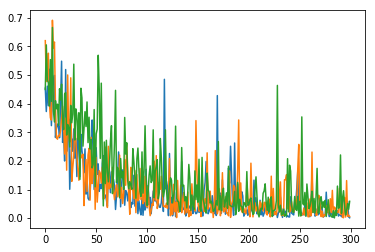

In [251]:
plt.plot(Loss[0])
plt.plot(Loss[1])
plt.plot(Loss[2])
plt.savefig("EEGNet_loss.png", dpi=300)
plt.show()

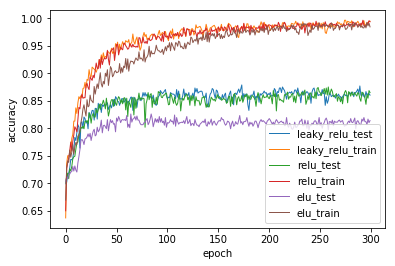

In [249]:
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.plot(testAcc[0],label='leaky_relu_test',linewidth=1)
plt.plot(trainAcc[0],label='leaky_relu_train',linewidth=1)

plt.plot(testAcc[1],label='relu_test',linewidth=1)
plt.plot(trainAcc[1],label='relu_train',linewidth=1)

plt.plot(testAcc[2],label='elu_test',linewidth=1)
plt.plot(trainAcc[2],label='elu_train',linewidth=1)

plt.legend(loc='lower right')
plt.savefig("EEGNet_acc.png", dpi=300)
plt.show()

### DeepConvNet

In [254]:
BATCH_SIZE=32
LR=5e-4
EPOCHS=300
loss_func=nn.CrossEntropyLoss()

train_loader=Data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader=Data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [255]:
actList=[nn.ReLU(),nn.LeakyReLU(),nn.ELU(alpha=1.)]
actStr=['ReLU','LeakyReLU','ELU']
trainAcc=[]
testAcc=[]
Loss=[]
count=0

for a in actList:
    model=DeepConvNet(a)
    model.cuda()
    optimizer=optim.Adam(model.parameters(),lr=LR)

    lossValues=[]
    trainAccValues=[]
    testAccValues=[]
    MaxAcc=0
    for epoch in range(EPOCHS):
        model.train()
        predicted=[]
        acc=0
        for index,(x,y) in enumerate(train_loader):
            x=Variable(x)
            y=y.view(-1).long()
            _y=model(x)
            loss=loss_func(_y,y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            y=y.cpu().numpy()
            _y=_y.cpu().detach().numpy()
            predicts=(np.argmax(_y,axis=1)==y)
            acc+=np.count_nonzero(predicts)
        
        print(a,"Epoch: [%3d], Loss: %.5f" %(epoch + 1, loss.data))
        lossValues.append(loss.data)
        trainAccValues.append(acc/train_data.shape[0])
        
        model.eval()
        predicted=[]
        acc=0
        for index,(x,y) in enumerate(test_loader):
            _y=model(x)
            y=y.cpu().numpy()
            _y=_y.cpu().detach().numpy()
            predicts=(np.argmax(_y,axis=1)==y)
            acc+=np.count_nonzero(predicts)
        if (acc/test_data.shape[0])>MaxAcc:
            MaxAcc=acc/test_data.shape[0]
            torch.save(model, actStr[count]+'_DeepConvNet.pkl') 
        testAccValues.append(acc/test_data.shape[0])
    testAcc.append(testAccValues)
    trainAcc.append(trainAccValues)
    Loss.append(lossValues)
    print(a," Acc: "+str(MaxAcc))
    count+=1

ReLU() Epoch: [  1], Loss: 0.65967


C:\Users\ec131b\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DeepConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ec131b\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


ReLU() Epoch: [  2], Loss: 0.66920
ReLU() Epoch: [  3], Loss: 0.65286
ReLU() Epoch: [  4], Loss: 0.45035
ReLU() Epoch: [  5], Loss: 0.51438
ReLU() Epoch: [  6], Loss: 0.53910
ReLU() Epoch: [  7], Loss: 0.50711
ReLU() Epoch: [  8], Loss: 0.50509
ReLU() Epoch: [  9], Loss: 0.42193
ReLU() Epoch: [ 10], Loss: 0.78766
ReLU() Epoch: [ 11], Loss: 0.47211
ReLU() Epoch: [ 12], Loss: 0.59524
ReLU() Epoch: [ 13], Loss: 0.51689
ReLU() Epoch: [ 14], Loss: 0.66411
ReLU() Epoch: [ 15], Loss: 0.60079
ReLU() Epoch: [ 16], Loss: 0.31237
ReLU() Epoch: [ 17], Loss: 0.56331
ReLU() Epoch: [ 18], Loss: 0.38366
ReLU() Epoch: [ 19], Loss: 0.81108
ReLU() Epoch: [ 20], Loss: 0.27525
ReLU() Epoch: [ 21], Loss: 0.48964
ReLU() Epoch: [ 22], Loss: 0.45595
ReLU() Epoch: [ 23], Loss: 0.39418
ReLU() Epoch: [ 24], Loss: 0.30861
ReLU() Epoch: [ 25], Loss: 0.62954
ReLU() Epoch: [ 26], Loss: 0.74390
ReLU() Epoch: [ 27], Loss: 0.52622
ReLU() Epoch: [ 28], Loss: 0.43149
ReLU() Epoch: [ 29], Loss: 0.42715
ReLU() Epoch: [ 30],

ReLU() Epoch: [236], Loss: 0.11613
ReLU() Epoch: [237], Loss: 0.06727
ReLU() Epoch: [238], Loss: 0.02896
ReLU() Epoch: [239], Loss: 0.05743
ReLU() Epoch: [240], Loss: 0.06872
ReLU() Epoch: [241], Loss: 0.05653
ReLU() Epoch: [242], Loss: 0.20178
ReLU() Epoch: [243], Loss: 0.16296
ReLU() Epoch: [244], Loss: 0.08196
ReLU() Epoch: [245], Loss: 0.11834
ReLU() Epoch: [246], Loss: 0.05061
ReLU() Epoch: [247], Loss: 0.05748
ReLU() Epoch: [248], Loss: 0.07813
ReLU() Epoch: [249], Loss: 0.08146
ReLU() Epoch: [250], Loss: 0.04949
ReLU() Epoch: [251], Loss: 0.05558
ReLU() Epoch: [252], Loss: 0.12729
ReLU() Epoch: [253], Loss: 0.32871
ReLU() Epoch: [254], Loss: 0.14824
ReLU() Epoch: [255], Loss: 0.10144
ReLU() Epoch: [256], Loss: 0.36454
ReLU() Epoch: [257], Loss: 0.11492
ReLU() Epoch: [258], Loss: 0.07562
ReLU() Epoch: [259], Loss: 0.16627
ReLU() Epoch: [260], Loss: 0.02991
ReLU() Epoch: [261], Loss: 0.14307
ReLU() Epoch: [262], Loss: 0.01091
ReLU() Epoch: [263], Loss: 0.10228
ReLU() Epoch: [264],

LeakyReLU(negative_slope=0.01) Epoch: [100], Loss: 0.25238
LeakyReLU(negative_slope=0.01) Epoch: [101], Loss: 0.37179
LeakyReLU(negative_slope=0.01) Epoch: [102], Loss: 0.17258
LeakyReLU(negative_slope=0.01) Epoch: [103], Loss: 0.36447
LeakyReLU(negative_slope=0.01) Epoch: [104], Loss: 0.12033
LeakyReLU(negative_slope=0.01) Epoch: [105], Loss: 0.37727
LeakyReLU(negative_slope=0.01) Epoch: [106], Loss: 0.29402
LeakyReLU(negative_slope=0.01) Epoch: [107], Loss: 0.33847
LeakyReLU(negative_slope=0.01) Epoch: [108], Loss: 0.24402
LeakyReLU(negative_slope=0.01) Epoch: [109], Loss: 0.11085
LeakyReLU(negative_slope=0.01) Epoch: [110], Loss: 0.29243
LeakyReLU(negative_slope=0.01) Epoch: [111], Loss: 0.17196
LeakyReLU(negative_slope=0.01) Epoch: [112], Loss: 0.23833
LeakyReLU(negative_slope=0.01) Epoch: [113], Loss: 0.09845
LeakyReLU(negative_slope=0.01) Epoch: [114], Loss: 0.15352
LeakyReLU(negative_slope=0.01) Epoch: [115], Loss: 0.34910
LeakyReLU(negative_slope=0.01) Epoch: [116], Loss: 0.091

LeakyReLU(negative_slope=0.01) Epoch: [238], Loss: 0.12154
LeakyReLU(negative_slope=0.01) Epoch: [239], Loss: 0.10148
LeakyReLU(negative_slope=0.01) Epoch: [240], Loss: 0.15072
LeakyReLU(negative_slope=0.01) Epoch: [241], Loss: 0.11193
LeakyReLU(negative_slope=0.01) Epoch: [242], Loss: 0.19053
LeakyReLU(negative_slope=0.01) Epoch: [243], Loss: 0.02804
LeakyReLU(negative_slope=0.01) Epoch: [244], Loss: 0.06011
LeakyReLU(negative_slope=0.01) Epoch: [245], Loss: 0.04922
LeakyReLU(negative_slope=0.01) Epoch: [246], Loss: 0.23341
LeakyReLU(negative_slope=0.01) Epoch: [247], Loss: 0.18443
LeakyReLU(negative_slope=0.01) Epoch: [248], Loss: 0.25129
LeakyReLU(negative_slope=0.01) Epoch: [249], Loss: 0.20755
LeakyReLU(negative_slope=0.01) Epoch: [250], Loss: 0.20687
LeakyReLU(negative_slope=0.01) Epoch: [251], Loss: 0.05137
LeakyReLU(negative_slope=0.01) Epoch: [252], Loss: 0.08520
LeakyReLU(negative_slope=0.01) Epoch: [253], Loss: 0.27261
LeakyReLU(negative_slope=0.01) Epoch: [254], Loss: 0.079

ELU(alpha=1.0) Epoch: [103], Loss: 0.09813
ELU(alpha=1.0) Epoch: [104], Loss: 0.15038
ELU(alpha=1.0) Epoch: [105], Loss: 0.46085
ELU(alpha=1.0) Epoch: [106], Loss: 0.16819
ELU(alpha=1.0) Epoch: [107], Loss: 0.14948
ELU(alpha=1.0) Epoch: [108], Loss: 0.09679
ELU(alpha=1.0) Epoch: [109], Loss: 0.19201
ELU(alpha=1.0) Epoch: [110], Loss: 0.13215
ELU(alpha=1.0) Epoch: [111], Loss: 0.14915
ELU(alpha=1.0) Epoch: [112], Loss: 0.21835
ELU(alpha=1.0) Epoch: [113], Loss: 0.12591
ELU(alpha=1.0) Epoch: [114], Loss: 0.04735
ELU(alpha=1.0) Epoch: [115], Loss: 0.28480
ELU(alpha=1.0) Epoch: [116], Loss: 0.03575
ELU(alpha=1.0) Epoch: [117], Loss: 0.33641
ELU(alpha=1.0) Epoch: [118], Loss: 0.21824
ELU(alpha=1.0) Epoch: [119], Loss: 0.08060
ELU(alpha=1.0) Epoch: [120], Loss: 0.21118
ELU(alpha=1.0) Epoch: [121], Loss: 0.16895
ELU(alpha=1.0) Epoch: [122], Loss: 0.15632
ELU(alpha=1.0) Epoch: [123], Loss: 0.16429
ELU(alpha=1.0) Epoch: [124], Loss: 0.09329
ELU(alpha=1.0) Epoch: [125], Loss: 0.14802
ELU(alpha=1

ELU(alpha=1.0) Epoch: [293], Loss: 0.01290
ELU(alpha=1.0) Epoch: [294], Loss: 0.13647
ELU(alpha=1.0) Epoch: [295], Loss: 0.00412
ELU(alpha=1.0) Epoch: [296], Loss: 0.03459
ELU(alpha=1.0) Epoch: [297], Loss: 0.04592
ELU(alpha=1.0) Epoch: [298], Loss: 0.00246
ELU(alpha=1.0) Epoch: [299], Loss: 0.05303
ELU(alpha=1.0) Epoch: [300], Loss: 0.09084
ELU(alpha=1.0)  Acc: 0.8194444444444444


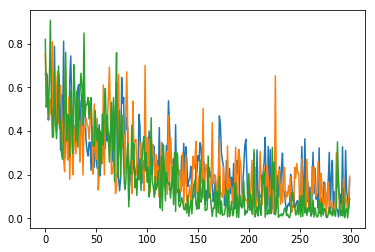

In [256]:
plt.plot(Loss[0])
plt.plot(Loss[1])
plt.plot(Loss[2])
plt.savefig("EEGNet_loss.png", dpi=300)
plt.show()

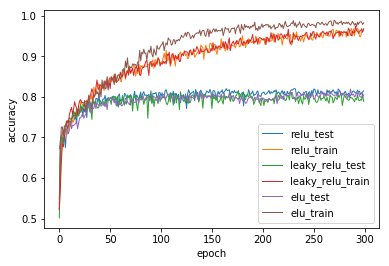

In [257]:
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(testAcc[0],label='relu_test',linewidth=1)
plt.plot(trainAcc[0],label='relu_train',linewidth=1)

plt.plot(testAcc[1],label='leaky_relu_test',linewidth=1)
plt.plot(trainAcc[1],label='leaky_relu_train',linewidth=1)

plt.plot(testAcc[2],label='elu_test',linewidth=1)
plt.plot(trainAcc[2],label='elu_train',linewidth=1)

plt.legend(loc='lower right')
plt.savefig("DeepConvNet_acc.png",dpi=300)
plt.show()